In [574]:
import json
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

## 1. Setup and Benchmark Properties

In [575]:
def summarise_fol(path):
    tasks = json.load(open(path))
    meta = [t["metadata"] for t in tasks]
    counts = {
        k: Counter(m[k] for m in meta)
        for k in ["num_rules","num_base_facts","proof_depth","allow_recursion","reasoning_type"]
    }
    counts["label"] = Counter(t["t"] for t in tasks)
    return len(tasks), counts


n_fol, counts_fol = summarise_fol("first_order_benchmark.json")
print(f"FOL tasks: {n_fol}")
for k,v in counts_fol.items():
    print(f"  {k}: {dict(v)}")

FOL tasks: 1279
  num_rules: {5: 147, 15: 273, 25: 378, 35: 481}
  num_base_facts: {4: 233, 8: 260, 12: 261, 16: 260, 20: 265}
  proof_depth: {1: 364, 5: 354, 10: 284, 20: 186, 30: 91}
  allow_recursion: {True: 638, False: 641}
  reasoning_type: {'deduction': 579, 'abduction': 700}
  label: {'true': 579, 'false': 700}


## 2. Load All Model Results

In [576]:
FILES = {
    "llama2": [("unshuffled","results/llama2_fol_unshuffled.json"),
               ("shuffled",  "results/llama2_fol_shuffled.json")],
    "flan_t5":[("unshuffled","results/flan_t5_fol_unshuffled.json"),
               ("shuffled",  "results/flan_t5_fol_shuffled.json")],
    "gemma2": [("unshuffled","results/gemma2_fol_unshuffled.json"),
               ("shuffled",  "results/gemma2_fol_shuffled.json")],
    # "mistral":[("unshuffled","results/mistral7b_fol_unshuffled.json"),
    #            ("shuffled",  "results/mistral7b_fol_shuffled.json")],
}

In [577]:
records = []
for model, runs in FILES.items():
    for order, fn in runs:
        data = json.load(open(fn))
        for rec in data:
            records.append({
                "model": model,
                "order": order,
                "t": rec["t"].lower(),
                "pred": rec.get("pred","").lower(),
                **rec["metadata"]
            })

df = pd.DataFrame(records)
df["correct"] = (df["t"] == df["pred"])
print(f"\nLoaded {len(df)} predictions across {df['model'].nunique()} models.")

df.head()


Loaded 7674 predictions across 3 models.


,model,order,t,pred,num_rules,max_body_length,allow_recursion,branching_factor,proof_depth,num_base_facts,depth,reasoning_type,correct
0,llama2,unshuffled,true,true,5,3,True,2,1,4,1,deduction,True
1,llama2,unshuffled,false,true,5,3,True,2,1,4,not applicable,deduction,False
2,llama2,unshuffled,true,true,5,3,True,2,1,4,1,abduction,True
3,llama2,unshuffled,false,true,5,3,True,2,1,4,not applicable,abduction,False
4,llama2,unshuffled,false,true,5,3,True,2,1,4,not applicable,abduction,False


## 3. Overall Accuracy Table

In [578]:
overall = (
    df
    .groupby(["model","order"])["correct"]
    .mean().mul(100).round(1)
    .unstack("order")
)
print("Overall accuracy (%) by model / benchmark:")
display(overall)


Overall accuracy (%) by model / benchmark:


order,shuffled,unshuffled
model,,
flan_t5,78.2,80.4
gemma2,81.4,83.8
llama2,45.9,50.4


## 4. Plotting Functions

In [579]:
def two_panel_plot(func, df, param_name, ylabel, title):
    fig, axes = plt.subplots(1,2,figsize=(12,4), sharey=True)
    for ax, order in zip(axes, ["unshuffled","shuffled"]):
        sub = df[df["order"]==order]
        func(sub, ax, f"{title} ({order})")
    fig.suptitle(title)
    fig.tight_layout(rect=[0,0,1,0.93])
    plt.show()

In [580]:
def plot_vs_depth(data, ax, title):
    grp = data[data["t"]=="true"].groupby(["proof_depth","model"])["correct"].mean().mul(100).reset_index()
    for m,sub in grp.groupby("model"):
        ax.plot(sub["proof_depth"], sub["correct"], marker="o", label=m)
    ax.set(xlabel="Proof Depth", ylabel="Accuracy (%)", title=title, ylim=(0,100))
    ax.legend(); ax.grid(alpha=0.3)

In [581]:
def plot_vs_rules(data, ax, title):
    grp = data.groupby(["num_rules","model"])["correct"].mean().mul(100).reset_index()
    for m,sub in grp.groupby("model"):
        ax.plot(sub["num_rules"], sub["correct"], marker="o", label=m)
    ax.set(xlabel="Number of Rules", ylabel="Accuracy (%)", title=title, xticks=[5,15,25,35], ylim=(0,100))
    ax.legend(); ax.grid(alpha=0.3)

In [582]:
def plot_vs_facts(data, ax, title):
    grp = data.groupby(["num_base_facts","model"])["correct"].mean().mul(100).reset_index()
    for m,sub in grp.groupby("model"):
        ax.plot(sub["num_base_facts"], sub["correct"], marker="o", label=m)
    ax.set(xlabel="Number of Facts", ylabel="Accuracy (%)", title=title, xticks=sorted(data["num_base_facts"].unique()), ylim=(0,100))
    ax.legend(); ax.grid(alpha=0.3)

In [583]:
def plot_vs_recursion(data, ax, title):
    grp = data.groupby(["allow_recursion","model"])["correct"].mean().mul(100).reset_index()
    for m,sub in grp.groupby("model"):
        ax.bar(sub["allow_recursion"].astype(str)+"_"+m, sub["correct"], label=m)
    ax.set(xlabel="Recursive?", ylabel="Accuracy (%)", title=title, ylim=(0,100))
    ax.legend(); ax.grid(alpha=0.3)

In [584]:
def plot_vs_reasoning(data, ax, title):
    grp = data.groupby(["reasoning_type","model"])["correct"].mean().mul(100).reset_index()
    for i,(rt,sub) in enumerate(grp.groupby("reasoning_type")):
        ax.bar([i + 0.2*j for j in range(len(sub))], sub["correct"], width=0.2, label=sub["model"].tolist()[0])
    ax.set(xlabel="Reasoning Type", ylabel="Accuracy (%)", title=title, xticks=[0,1], xticklabels=grp["reasoning_type"].unique(), ylim=(0,100))
    ax.legend(); ax.grid(alpha=0.3)

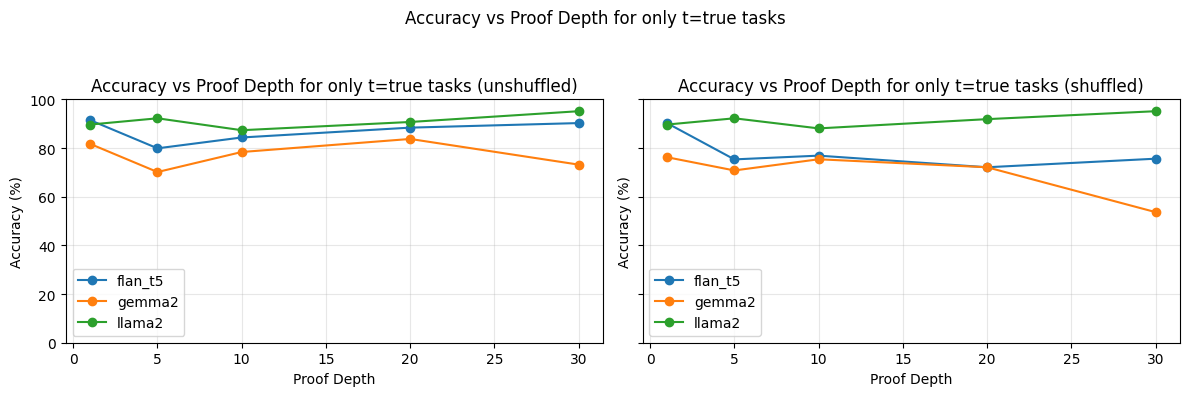

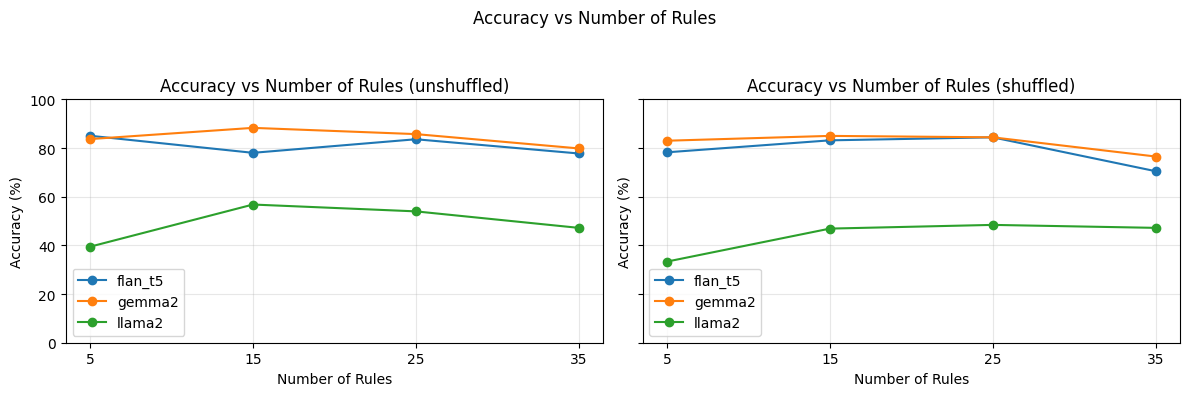

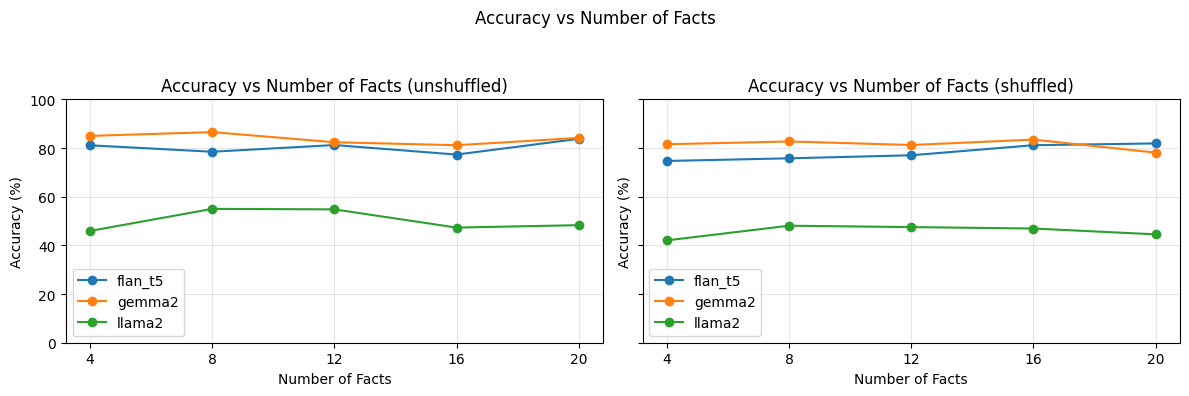

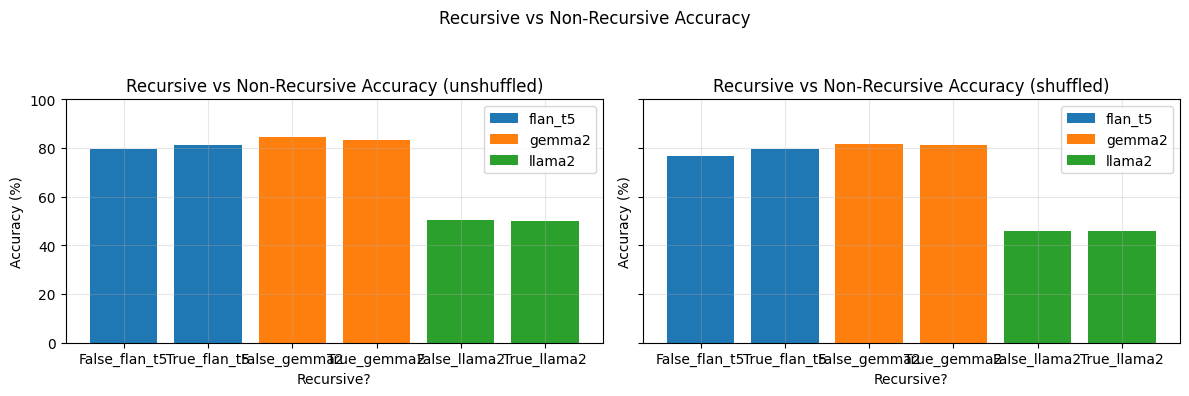

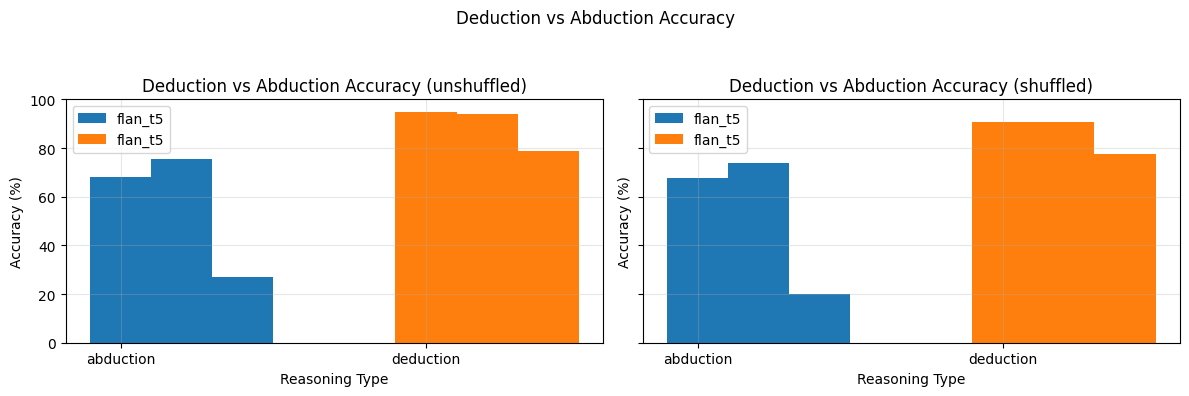

In [585]:
two_panel_plot(plot_vs_depth,     df, "proof_depth", None, "Accuracy vs Proof Depth for only t=true tasks")
two_panel_plot(plot_vs_rules,     df, "num_rules",   None, "Accuracy vs Number of Rules")
two_panel_plot(plot_vs_facts,     df, "num_base_facts",None, "Accuracy vs Number of Facts")
two_panel_plot(plot_vs_recursion, df, "allow_recursion",None, "Recursive vs Non-Recursive Accuracy")
two_panel_plot(plot_vs_reasoning, df, "reasoning_type", None, "Deduction vs Abduction Accuracy")